In [ ]:
! pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import lightgbm as lgb
import seaborn as sns
from sklearn import metrics
from scipy.stats import kstest
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer


random.seed(42)

In [ ]:
df_all = pd.read_csv('clean_df.csv')
df_all['time_close'] = pd.to_datetime(df_all['time_close'])
df = df_all.loc[df_all['symbol_id'] == 'LTC_2'].copy().reset_index(drop=True)
symbols = ['DOGE_74', 'ETH_1027', 'XRP_52', 'XLM_512', 'BTC_1', 'XMR_328']
for sym in symbols:
    df[(sym)] = df_all.loc[df_all['symbol_id'] ==  sym]['price change'].values
df.drop(columns=['symbol_id', 'tomorrow change'], inplace=True)
cols = ['SPY', 'Oil', '10Y Treasury', 'Gold', 'EUR_USD', 'marketcap']
for col in cols:
    df[(col)] = df[col].pct_change()
df['target'] = df['close'].shift(-1)
df["target"] = df["target"].pct_change()
df.dropna(inplace=True)
df.head()

,time_close,close,marketcap,month,day,weekday,day of week,price change,SPY,VIX,...,Gold,Oil,EUR_USD,DOGE_74,ETH_1027,XRP_52,XLM_512,BTC_1,XMR_328,target
1,2015-08-11,3.95867,0.005367,8,11,1,1,0.004680,-0.009023,13.71,...,0.003079,-0.041815,0.004737,-0.004904,0.049628,-0.006013,0.059908,-0.005849,-0.050167,0.045485
2,2015-08-12,4.13873,0.046198,8,12,2,1,0.045485,0.001198,13.61,...,0.014084,0.005107,0.002275,0.022335,0.434049,-0.021986,-0.037425,0.018745,-0.063835,-0.048998
3,2015-08-13,3.93594,-0.048358,8,13,3,1,-0.048998,-0.001244,13.49,...,-0.006677,-0.024711,0.010770,-0.027089,0.150800,-0.035912,-0.005804,-0.011792,0.013810,-0.011728
4,2015-08-14,3.88978,-0.011056,8,14,4,1,-0.011728,0.003642,12.83,...,-0.002510,0.006394,0.000000,-0.018380,0.598189,-0.014253,-0.040830,-0.006690,-0.061253,0.037552
5,2015-08-15,4.03585,0.038235,8,15,5,0,0.037552,0.000000,12.83,...,0.000000,0.000000,0.000000,0.006813,-0.171918,0.023481,0.012725,0.005850,0.054035,-0.024156


In [ ]:
for col in df.columns[2:]:
  timeseries = df[col]
  result = adfuller(timeseries)
  print(f'ADF Statistic: {result[0]:.3f}')
  print(f'p-value: {result[1]:.3E}')
  if result[0] > result[4]["5%"]:
      conclusion=f"Failed to Reject H_0 at 5% -> {col} Time Series is Non-Stationary"
  else:
      conclusion=f"Reject H_0 at at 5% -> {col} Time Series is Stationary"
  print(conclusion)

ADF Statistic: -17.866
p-value: 3.040E-30
Reject H_0 at at 5% -> marketcap Time Series is Stationary
ADF Statistic: -4.405
p-value: 2.914E-04
Reject H_0 at at 5% -> month Time Series is Stationary
ADF Statistic: -18.808
p-value: 2.023E-30
Reject H_0 at at 5% -> day Time Series is Stationary
ADF Statistic: -15.783
p-value: 1.124E-28
Reject H_0 at at 5% -> weekday Time Series is Stationary
ADF Statistic: -21.546
p-value: 0.000E+00
Reject H_0 at at 5% -> day of week Time Series is Stationary
ADF Statistic: -17.872
p-value: 3.026E-30
Reject H_0 at at 5% -> price change Time Series is Stationary
ADF Statistic: -10.647
p-value: 4.755E-19
Reject H_0 at at 5% -> SPY Time Series is Stationary
ADF Statistic: -4.396
p-value: 3.018E-04
Reject H_0 at at 5% -> VIX Time Series is Stationary
ADF Statistic: -9.170
p-value: 2.401E-15
Reject H_0 at at 5% -> 10Y Treasury Time Series is Stationary
ADF Statistic: -51.833
p-value: 0.000E+00
Reject H_0 at at 5% -> Gold Time Series is Stationary
ADF Statistic:

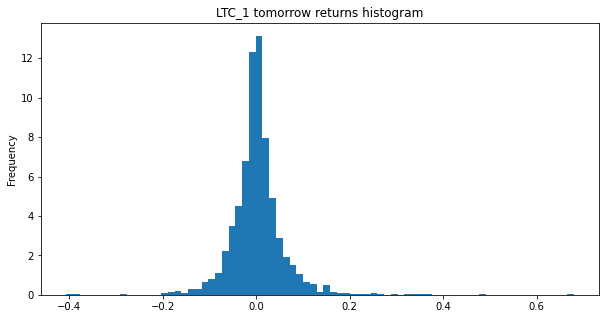

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
df['target'].plot.hist(density=1, bins=75, ax=ax)
plt.title('LTC_1 tomorrow returns histogram')
plt.show()

In [ ]:
kstest(df['target'], 'norm')

KstestResult(statistic=0.43622912457664237, pvalue=0.0)

In [ ]:
def relative_strength_idx(df, n=14):
    close = df['close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi
df['RSI'] = relative_strength_idx(df).fillna(0)

In [ ]:
EMA_12 = pd.Series(df['close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

In [ ]:
price = df[['close', 'time_close']]
df.dropna(inplace=True)
cut_df = df.loc[df['time_close'] >= '2020-09-25'].copy()
df.reset_index(inplace=True, drop=True)
df.head()

,time_close,close,marketcap,month,day,weekday,day of week,price change,SPY,VIX,...,DOGE_74,ETH_1027,XRP_52,XLM_512,BTC_1,XMR_328,target,RSI,MACD,MACD_signal
0,2015-09-13,2.83492,-0.042931,9,13,6,0,-0.043223,0.000000,23.200001,...,-0.026091,0.020416,-0.028014,-0.006689,-0.019671,-0.032950,-0.002141,48.272250,-0.086472,-0.106000
1,2015-09-14,2.82885,-0.001792,9,14,0,1,-0.002141,-0.003710,24.250000,...,-0.012915,-0.071770,0.040454,-0.018533,-0.017406,-0.037079,0.005981,49.858075,-0.087630,-0.101884
2,2015-09-15,2.84577,0.006355,9,15,1,1,0.005981,0.012499,22.540001,...,0.001818,-0.056969,-0.133437,-0.003234,-0.000735,0.059949,-0.005289,49.405560,-0.086255,-0.098464
3,2015-09-16,2.83072,-0.004935,9,16,2,1,-0.005289,0.008667,21.350000,...,-0.007839,0.070366,0.045205,0.012599,-0.002375,0.032490,-0.009340,50.828950,-0.085323,-0.095642
4,2015-09-17,2.80428,-0.008993,9,17,3,1,-0.009340,-0.002248,21.139999,...,-0.015193,-0.039755,-0.038219,0.003365,-0.006120,0.010640,0.053600,50.219171,-0.085618,-0.093521


In [ ]:
y = cut_df[['target', 'time_close']]
x = cut_df.copy()

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = False)

In [ ]:
date = '2022-05-03'
x_train = x.loc[x['time_close'] < date].copy()
x_test = x.loc[x['time_close'] >= date].copy()
y_train = y.loc[y['time_close'] < date].copy()
y_test = y.loc[y['time_close'] >= date].copy()

In [ ]:
date = x_test['time_close'][x_test.index[0]]
test_price = x_test.loc[x_test['time_close'] >= date]['close'].copy()

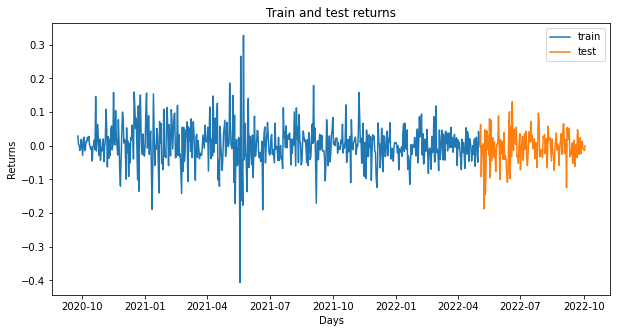

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(y_train.time_close, y_train.target, label='train')
plt.plot(y_test.time_close, y_test.target, label='test')
plt.ylabel('Returns')
plt.xlabel('Days')
plt.title('Train and test returns')
plt.legend()
plt.show()

In [ ]:
x_train.drop(columns=['time_close', 'close', 'target'], inplace = True)
x_test.drop(columns=['time_close', 'close', 'target'], inplace = True)

In [ ]:
# lower, upper = y_train.target.quantile([.25, .75])

In [ ]:
train_dates = y_train['time_close'].values
test_dates = y_test['time_close'].values

y_train.drop(columns=['time_close'], inplace=True)
y_test.drop(columns=['time_close'], inplace=True)

In [ ]:
# y_test_c = np.where(y_test < lower, 0, np.where(y_test <= upper, 1, 2))
# y_train_c = np.where(y_train < lower, 0, np.where(y_train <= upper, 1, 2))

In [ ]:
y_test_c = np.where(y_test < 0, 0, 1)
y_train_c = np.where(y_train < 0, 0, 1)

In [ ]:
print((y_train_c == 0).sum())
print((y_train_c == 1).sum())

275
309


In [ ]:
print((y_test_c == 0).sum())
print((y_test_c == 1).sum())

75
78


In [ ]:
# x_train = x_train[['price change', 'VIX', 'SPY', 'ETH_1027', 'XRP_52', 'XLM_512', 'BTC_1', 'XMR_328']]
# x_test = x_test[['price change', 'VIX', 'SPY', 'ETH_1027', 'XRP_52', 'XLM_512', 'BTC_1', 'XMR_328']]

In [ ]:
# for col in x_train.columns:
#     x_train[(col)] = np.where(x_train[(col)] < 0, 0, 1)
#     x_test[(col)] = np.where(x_test[(col)] < 0, 0, 1)

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)
# x_test = pd.DataFrame(scaler.transform(x_test), columns = x_train.columns)

In [ ]:
# param_grid = {'n_estimators':[5, 10, 25, 35, 45, 55, 75, 100]}
# reg = lgb.LGBMClassifier()
# grid = GridSearchCV(estimator = reg, param_grid = param_grid, scoring = 'f1_macro', cv = 5, verbose = 1, return_train_score= True)
# grid.fit(x_train, y_train_c.ravel())

In [ ]:
# fig, ax = plt.subplots(figsize = (10, 5))
# plt.plot(param_grid['n_estimators'], grid.cv_results_['mean_test_score'], label='test')
# plt.plot(param_grid['n_estimators'], grid.cv_results_['mean_train_score'], label='train')
# plt.ylabel('F1 score')
# plt.xlabel('n_estimators')
# plt.title('F1 score vs n_estimators')
# plt.legend()
# plt.show()

In [ ]:
best_reg = lgb.LGBMClassifier(n_estimator = 200)
best_reg.fit(x_train, y_train_c.ravel())

LGBMClassifier(n_estimator=200)

In [ ]:
pred = best_reg.predict(x_test)
pred_proba = best_reg.predict_proba(x_test)

In [ ]:
def scores(y_true, y_pred, pred_proba):
  acc = metrics.accuracy_score(y_true, y_pred)
  prec = metrics.precision_score(y_true, y_pred)
  sens = metrics.recall_score(y_true, y_pred, pos_label=0)
  rec = metrics.recall_score(y_true, y_pred)
  f1 = metrics.f1_score(y_true, y_pred)
  roc_auc = metrics.roc_auc_score(np.squeeze((np.eye(4)[y_true]),1), pred_proba)

  print('Accuracy is :',round(acc,3))
  print('Precision is :',round(prec,3))
  print('Sensitivity is :',round(sens,3))
  print('Recall is :',round(rec,3))
  print('F1 score is :',round(f1,3))
  print('AUC is :',round(roc_auc,3))

In [ ]:
scores(y_test_c, pred, pred_proba)

Accuracy is : 0.556
Precision is : 0.562
Sensitivity is : 0.533
Recall is : 0.577
F1 score is : 0.57
AUC is : 0.614


In [ ]:
train_pred = best_reg.predict(x_train)
print('Train accuracy is :', metrics.accuracy_score(y_train_c, train_pred))
print('Train precision is :', metrics.precision_score(y_train_c, train_pred))
print('Train sensitivity is :', metrics.recall_score(y_train_c, train_pred, pos_label=0))
print('Train f1 score is :', metrics.f1_score(y_train_c, train_pred))

Train accuracy is : 1.0
Train precision is : 1.0
Train sensitivity is : 1.0
Train f1 score is : 1.0


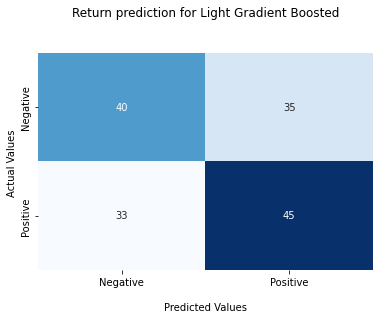

In [ ]:
cf_matrix = metrics.confusion_matrix(y_test_c, pred)


ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',cbar=False,fmt = 'g')

ax.set_title('Return prediction for Light Gradient Boosted\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

plt.show()

In [ ]:
sns.reset_orig()

In [ ]:
guess_neg = np.nonzero(np.where(pred == 0, 1, 0))
guess_pos = np.nonzero(np.where(pred == 1, 1, 0))
y_test.reset_index(drop=True, inplace=True)
negative = y_test.iloc[guess_neg]
correct_neg = negative.loc[negative.target < 0]
positive = y_test.iloc[guess_pos]
correct_pos = positive.loc[positive.target > 0]

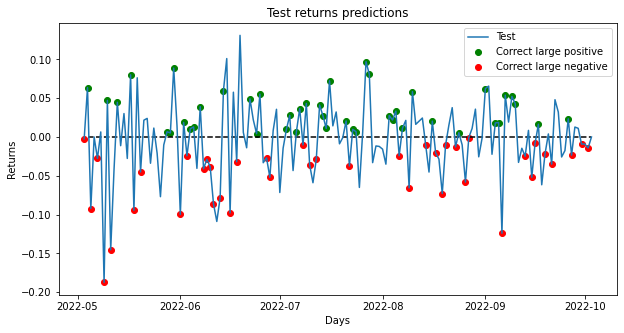

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(test_dates, y_test.target, label='Test')
plt.scatter(test_dates[correct_pos.index], y_test.iloc[correct_pos.index], c='g', marker = 'o', label='Correct large positive')
plt.scatter(test_dates[correct_neg.index], y_test.iloc[correct_neg.index], c='r', marker = 'o',label='Correct large negative')
ax.hlines(y=0, xmin=test_dates[1], xmax=test_dates[-1], color='k', linestyles='dashed')
plt.ylabel('Returns')
plt.xlabel('Days')
plt.title('Test returns predictions')
plt.legend()
plt.show()

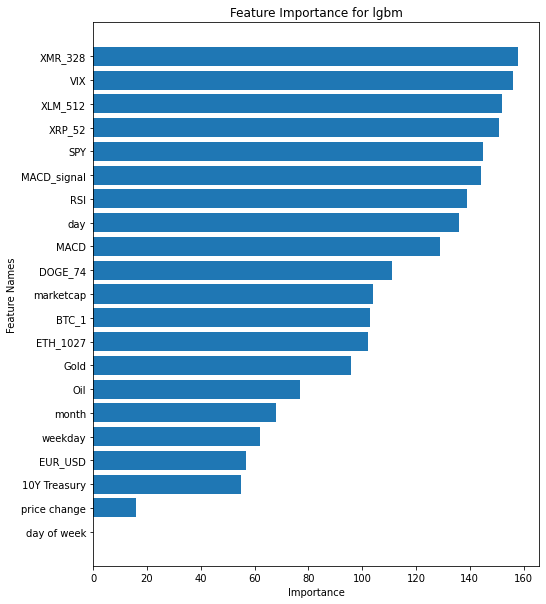

In [ ]:
importance = best_reg.feature_importances_.copy()
sorted_import = importance.argsort()
fig, ax = plt.subplots(figsize = (8, 10))
plt.barh(x_train.columns[sorted_import], importance[sorted_import])
plt.xlabel('Importance')
plt.ylabel('Feature Names')
plt.title('Feature Importance for lgbm')
plt.show()

In [ ]:
def apply_strategy(pred, test_price):
  money = [0]
  prices = []
  shares = [1000 / float(test_price.values[0])]
  for i in range(len(pred)):
      current_signal = pred[i]
      if i == 0:
        previous_signal = 1
      else:
        previous_signal = pred[i-1]
      if current_signal > 0:
        if previous_signal < 1: # buy
          shares.append(money[-1]/float(test_price.values[i]))
          prices.append(shares[-1] * float(test_price.values[i]))
          money.append(0)
        else:
          money.append(money[-1])
          prices.append(shares[-1] * float(test_price.values[i]))
          shares.append(shares[-1])
      else:
        if previous_signal > 0: #sell
          money.append(shares[-1] * float(test_price.values[i]))
          prices.append(shares[-1] * float(test_price.values[i]))
          shares.append(0)
        else:
          money.append(money[-1])
          prices.append(money[-1])
          shares.append(shares[-1])
  return prices

In [ ]:
prices = apply_strategy(pred, test_price)
print('$1000 investment using startegy: ', prices[-1])

$1000 investment using startegy:  1483.1823757826621


In [ ]:
print('$1000 investment using in buy and hold: ', (1000 / float(test_price.values[0]))*float(test_price.values[-1]))

$1000 investment using in buy and hold:  519.3747417374369


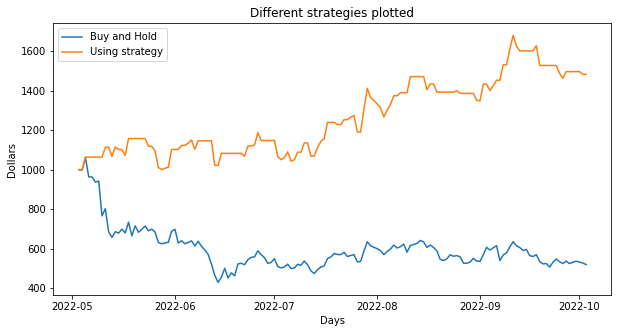

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(test_dates, (1000 / float(test_price.values[0])*test_price.values), label='Buy and Hold')
plt.plot(test_dates, prices, label='Using strategy')
plt.ylabel('Dollars')
plt.xlabel('Days')
plt.title('Different strategies plotted')
plt.legend()
plt.show()

In [ ]:
cv = TimeSeriesSplit(n_splits = 3)
model = lgb.LGBMClassifier(n_estimators = 200)
scoring = {'f1': make_scorer(metrics.f1_score),
           'acc': make_scorer(metrics.accuracy_score),
           'rec': make_scorer(metrics.recall_score),
           'pre': make_scorer(metrics.precision_score)}
x_cv = x.copy().drop(columns=['time_close', 'close', 'target'])
y_cv = y.copy().drop(columns='time_close')
y_cv = np.where(y_cv < 0, 0, 1)
scores = cross_validate(model , x_cv, y_cv.ravel(), scoring=scoring, cv=cv, return_train_score = True)

In [ ]:
print('f1 :', np.mean(scores['test_f1']))
print('acc :', np.mean(scores['test_acc']))
print('precision :', np.mean(scores['test_pre']))
print('recall :', np.mean(scores['test_rec']))

f1 : 0.5560310469616331
acc : 0.5398550724637681
precision : 0.5521448783248445
recall : 0.5601785040558385
